-------------------------------
-------------------------------
# Proyecto 1 - IA (CC3085)
* DULCE AMBROSIO - 231143
* DANIEL CHET - 231177
* GADIEL OCAÑA - 231270

-------------------------------
-------------------------------

-------------------------------
## Task 1.1 - Discretización del Mundo
-------------------------------

Convierte la imagen .bmp en una matriz discreta (grid) donde cada celda representa una baldosa del mapa.

Se agrupan los píxeles según un TILE_SIZ` definido para simplificar el mapa y clasificar cada tile en:
- **Pared (Negro)**: Obstáculos
- **Inicio (Rojo)**: Punto de partida
- **Meta (Verde)**: Objetivo
- **Libre (Blanco)**: Espacio transitable

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Se carga la imagen
img = Image.open("turing.bmp")
img = img.convert("RGB")
img_array = np.array(img)

print("Dimensiones:", img_array.shape)

Dimensiones: (640, 640, 3)


In [3]:
# Se define el tamaño de baldosa (tile), para no procesar
# pixel por pixel

TILE_SIZE = 2

In [4]:
height, width, _ = img_array.shape

height = height - (height % TILE_SIZE)
width = width - (width % TILE_SIZE)

img_array = img_array[:height, :width]

In [5]:
# Se crear el grid discreto
rows = height // TILE_SIZE
cols = width // TILE_SIZE

grid = np.zeros((rows, cols), dtype=object)

print("Grid size:", grid.shape)

Grid size: (320, 320)


In [6]:
# Se clasifica cada baldosa, tomando los pixeles,
# calculando el promedio RGB y clasificando según el color:
#   - Negro: pared
#   - Rojo: inicio
#   - Verde: meta
#   - Blanco: libre

start = None
goals = []

for i in range(rows):
    for j in range(cols):
        
        tile = img_array[
            i*TILE_SIZE:(i+1)* TILE_SIZE,
            j*TILE_SIZE:(j+1)* TILE_SIZE
        ]
        
        avg_color = tile.mean(axis=(0,1))
        r, g, b = avg_color
        
        # Negro - pared
        if r < 50 and g < 50 and b < 50:
            grid[i][j] = "WALL"
        
        # Rojo - inicio
        elif r > 200 and g < 50 and b < 50:
            grid[i][j] = "START"
            start = (i, j)
        
        # Verde - meta
        elif g > 200 and r < 50 and b < 50:
            grid[i][j] = "GOAL"
            goals.append((i, j))
        
        # Blanco - libre
        else:
            grid[i][j] = "FREE"


In [7]:
# Se verifica que haya detectado el inicio y la meta

print("Start:", start)
print("Goals:", goals)

Start: (221, 73)
Goals: [(124, 307), (124, 308), (124, 309), (124, 310), (125, 306), (125, 307), (125, 308), (125, 309), (125, 310), (125, 311), (126, 305), (126, 306), (126, 307), (126, 308), (126, 309), (126, 310), (126, 311), (127, 305), (127, 306), (127, 307), (127, 308), (127, 309), (127, 310), (127, 311), (127, 312), (128, 305), (128, 306), (128, 307), (128, 308), (128, 309), (128, 310), (128, 311), (128, 312), (129, 305), (129, 306), (129, 307), (129, 308), (129, 309), (129, 310), (129, 311), (130, 306), (130, 307), (130, 308), (130, 309), (130, 310), (130, 311), (131, 307), (131, 308), (131, 309), (131, 310), (183, 84), (183, 85), (183, 86), (183, 87), (184, 83), (184, 84), (184, 85), (184, 86), (184, 87), (184, 88), (185, 82), (185, 83), (185, 84), (185, 85), (185, 86), (185, 87), (185, 88), (186, 82), (186, 83), (186, 84), (186, 85), (186, 86), (186, 87), (186, 88), (187, 83), (187, 84), (187, 85), (187, 86), (187, 87), (187, 88), (188, 84), (188, 85), (188, 86), (188, 87), (

-------------------------------
## Task 1.2 - Implementación de Búsqueda No Informada
-------------------------------

Se implementa el framework de búsqueda usando POO, con una clase abstracta que representa el problema y algoritmos de búsqueda no informada para establecer la base de comparación.

**Algoritmos implementados:**
- **BFS (Breadth-First Search)**: Garantiza el menor número de pasos, explorando nivel por nivel
- **DFS (Depth-First Search)**: Explora caminos profundamente antes de retroceder

Se utiliza Graph Search (con conjunto de visitados) para evitar ciclos y backtracking innecesario.

In [8]:
# Se crea la clase abstracta del problema 
from abc import ABC, abstractmethod

class SearchProblem(ABC):
    
    @abstractmethod
    def getStartState(self):
        pass
    
    @abstractmethod
    def isGoalState(self, state):
        pass
    
    @abstractmethod
    def getSuccessors(self, state):
        pass

In [9]:
# Se crea la clase para implementar el MazeProblem 

class MazeProblem(SearchProblem):
    
    def __init__(self, grid, start, goals, img_array=None, tile_size=None):
        self.grid = grid
        self.start = start
        self.goals = goals
        self.img_array = img_array
        self.tile_size = tile_size
        self.rows = len(grid)
        self.cols = len(grid[0])
        
        # Modo con costos dinámicos (red neuronal) o modo simple (costo 1)
        self.use_dynamic_cost = (img_array is not None and tile_size is not None)

    # Devuelve el estado inicial
    def getStartState(self):
        return self.start
    
    # Devuelve True si el estado es un estado meta (verifica)
    def isGoalState(self, state):
        return state in self.goals
    
    # Genera movimientos validos
    # Verifica que no se salga del grid y que no sea una pared
    def getSuccessors(self, state):
    
        successors = []
        i, j = state
        
        directions = [
            (1, 0),   # abajo
            (-1, 0),  # arriba
            (0, 1),   # derecha
            (0, -1)   # izquierda
        ]
        
        for di, dj in directions:
            ni, nj = i + di, j + dj
            
            if 0 <= ni < self.rows and 0 <= nj < self.cols:
                
                if self.grid[ni][nj] != "WALL":
                    
                    #  calcular con red neuronal
                    if self.use_dynamic_cost:
                        # Obtener promedio RGB del tile vecino
                        tile = self.img_array[
                            ni*self.tile_size:(ni+1)*self.tile_size,
                            nj*self.tile_size:(nj+1)*self.tile_size
                        ]
                        
                        avg_color = tile.mean(axis=(0,1))
                        predicted_color = predict_color(avg_color)
                        
                        cost = color_cost_mapping.get(predicted_color, 5)
                    else:
                        # Modo simple: costo uniforme
                        cost = 1
                    
                    successors.append(((ni, nj), cost))
        
        return successors

In [10]:
# Se implementa el BFS para encontrar el camino con menor
# número de pasos ignorando costos

# Se visitan los niveles por profundidad
# Garantiza el menor número de pasos

from collections import deque

def bfs(problem):
    
    start = problem.getStartState()
    
    queue = deque()
    queue.append((start, []))
    
    visited = set() # Se usa para convertir el Tree Search en Graph Search
    
    while queue:
        
        state, path = queue.popleft()
        
        if problem.isGoalState(state):
            return path + [state]
        
        if state not in visited:
            visited.add(state)
            
            for successor, cost in problem.getSuccessors(state):
                queue.append((successor, path + [state]))
    
    return None


In [11]:
# Se implementan los DFS, para explorar
# caminos profundamente antes de retroceder

def dfs(problem):
    
    start = problem.getStartState()
    
    stack = [(start, [])]
    visited = set()
    
    while stack:
        
        state, path = stack.pop()
        
        if problem.isGoalState(state):
            return path + [state]
        
        if state not in visited:
            visited.add(state)
            
            for successor, cost in problem.getSuccessors(state):
                stack.append((successor, path + [state]))
    
    return None


In [12]:
# Prueba de BFS y DFS en el laberinto cargado 
# Se usa el problema con costo uniforme (todos los tiles cuestan 1)

problem = MazeProblem(grid, start, goals)

# Ejecutar ambos algoritmos
bfs_path = bfs(problem)
dfs_path = dfs(problem)

# Comparar resultados
print("=" * 50)
print("COMPARACIÓN: BFS vs DFS")
print("=" * 50)
print(f"BFS - Longitud del camino: {len(bfs_path)} pasos")
print(f"DFS - Longitud del camino: {len(dfs_path)} pasos")
print("=" * 50)
print(f"BFS garantiza el camino MÁS CORTO: {len(bfs_path) <= len(dfs_path)}")


COMPARACIÓN: BFS vs DFS
BFS - Longitud del camino: 608 pasos
DFS - Longitud del camino: 1384 pasos
BFS garantiza el camino MÁS CORTO: True


In [13]:
# Se muestra la ruta encontrada sobre la matriz discreta de manera gráfica
# Se crea una matriz numerica 
#   - 0 para paredes
#   - 1 para espacios libres
#  - 2 para la ruta encontrada

def visualize_path(grid, path):
    
    visual = np.zeros((len(grid), len(grid[0])))
    
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == "WALL":
                visual[i][j] = 0
            elif grid[i][j] == "FREE":
                visual[i][j] = 1
            elif grid[i][j] == "START":
                visual[i][j] = 3
            elif grid[i][j] == "GOAL":
                visual[i][j] = 4
    
    for (i,j) in path:
        visual[i][j] = 2
    
    plt.figure(figsize=(8,8))
    plt.imshow(visual, cmap="tab10")
    plt.title("Path Found")
    plt.colorbar()
    plt.show()

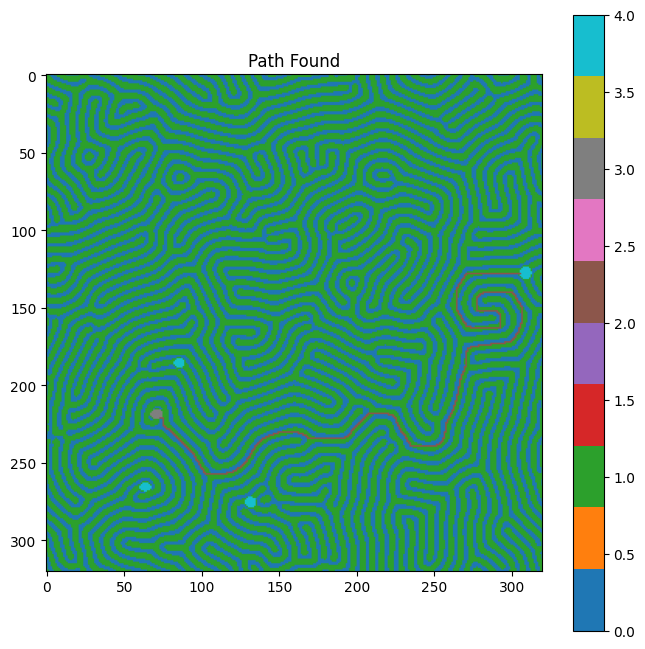

In [14]:
# Visualización del camino encontrado por BFS
visualize_path(grid, bfs_path)

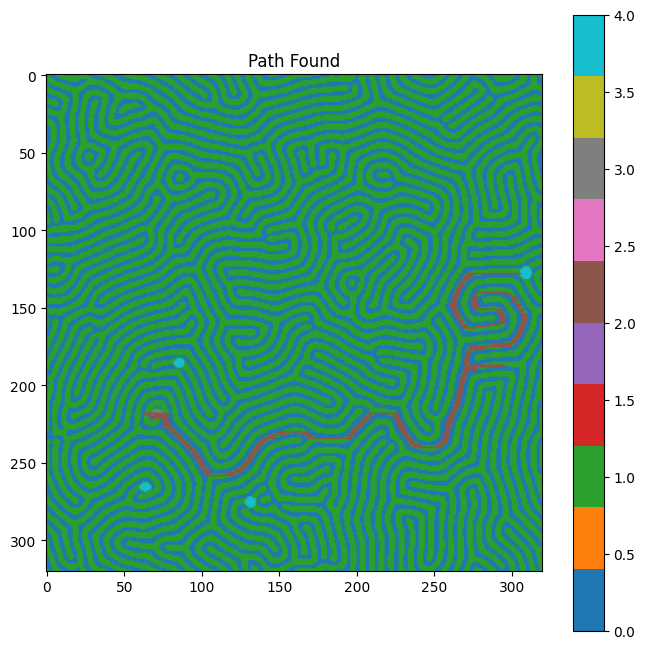

In [15]:
# Visualización del camino encontrado por DFS
visualize_path(grid, dfs_path)

-------------------------------
## Task 1.3 - Implementación de A* (Búsqueda Informada)
-------------------------------

Se implementa el algoritmo A* con heurística de Distancia Manhattan, la cual es admisible y consistente.

En esta versión inicial, se asume que moverse a cualquier cuadro transitable tiene costo uniforme = 1, lo que permite al algoritmo encontrar el camino más corto considerando tanto el costo acumulado g(n) como la estimación heurística h(n).

In [16]:
import heapq

def heuristic(state, goals):
    # Distancia Manhattan al goal más cercano
    return min(abs(state[0] - g[0]) + abs(state[1] - g[1]) for g in goals)

def astar(problem):
    
    start = problem.getStartState()
    
    open_set = []
    heapq.heappush(open_set, (0, start))
    
    came_from = {}
    g_score = {start: 0}
    
    visited_nodes = 0
    
    while open_set:
        
        _, current = heapq.heappop(open_set)
        visited_nodes += 1
        
        if problem.isGoalState(current):
            
            # reconstruir camino
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            
            return path, visited_nodes
        
        for successor, cost in problem.getSuccessors(current):
            
            tentative_g = g_score[current] + cost
            
            if successor not in g_score or tentative_g < g_score[successor]:
                
                came_from[successor] = current
                g_score[successor] = tentative_g
                
                f_score = tentative_g + heuristic(successor, problem.goals)
                
                heapq.heappush(open_set, (f_score, successor))
    
    return None, visited_nodes

In [17]:
# Prueba de A* en el laberinto (costo uniforme)
# En esta versión inicial, todos los movimientos tienen costo 1

path_astar, visited_astar = astar(problem)

print("=" * 50)
print("RESULTADOS: A* con Costo Uniforme")
print("=" * 50)
print(f"Longitud del camino: {len(path_astar)} pasos")
print(f"Nodos visitados: {visited_astar} nodos")
print("=" * 50)
print(f"A* encontró camino óptimo: {len(path_astar) == len(bfs_path)}")
print(f"A* exploró menos nodos que BFS/DFS: (más eficiente)")

RESULTADOS: A* con Costo Uniforme
Longitud del camino: 608 pasos
Nodos visitados: 5306 nodos
A* encontró camino óptimo: True
A* exploró menos nodos que BFS/DFS: (más eficiente)


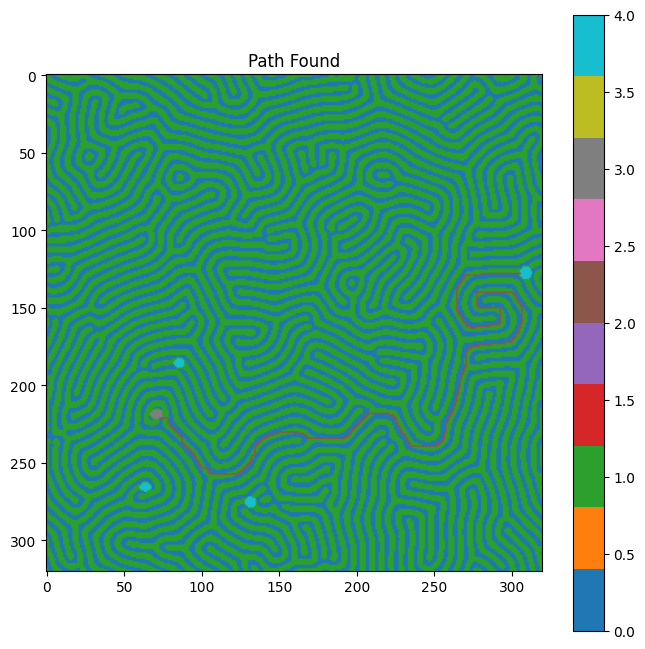

In [18]:
# Visualización del camino encontrado por A*
visualize_path(grid, path_astar)

-------------------------------
## Task 2.1 - Entrenamiento de Red Neuronal 
-------------------------------

Se entrena una Red Neuronal Multicapa (MLP) implementada desde cero para clasificar colores RGB en tipos de terreno.

**Arquitectura:**
- Capa de entrada: 3 neuronas (R, G, B normalizados)
- Capa oculta: 16 neuronas con activación ReLU
- Capa de salida: 11 clases con activación Softmax

**Entrenamiento:**
- Backpropagation manual con Gradient Descent
- Función de pérdida: Cross-Entropy
- Dataset: `final_data_colors.csv`

La red clasifica cada color RGB en una categoría de terreno que luego se mapea a un costo de movimiento.

In [19]:
# Se carge el dataset
import pandas as pd

# Cargar dataset
df = pd.read_csv("final_data_colors.csv")

# Ver primeras filas
df.head()

,red,green,blue,label
0,20,139,240,Blue
1,174,83,72,Brown
2,144,249,131,Green
3,168,25,156,Pink
4,30,182,136,Green


In [20]:
df.info()
df["label"].value_counts()

<class 'pandas.DataFrame'>
RangeIndex: 5052 entries, 0 to 5051
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   red     5052 non-null   int64
 1   green   5052 non-null   int64
 2   blue    5052 non-null   int64
 3   label   5052 non-null   str  
dtypes: int64(3), str(1)
memory usage: 158.0 KB


label
Green     1457
Blue      1107
Pink       579
Purple     553
Brown      376
Yellow     285
Red        236
Orange     205
Grey       174
Black       51
White       29
Name: count, dtype: int64

In [21]:
# Se mapean los colores a costos para usar en el A*
color_cost_mapping = {
    'Grey': 1,      # Pavimento 
    'Blue': 50,     # Agua 
    'White': 1,     # Libre
    'Green': 3      # Grama
}

In [22]:
# Se preparan los datos para la red
import numpy as np

# Extraer features
X = df[["red", "green", "blue"]].values

# Extraer etiquetas
y_text = df["label"].values

In [23]:
df["label"].unique()

<StringArray>
[  'Blue',  'Brown',  'Green',   'Pink', 'Yellow', 'Orange', 'Purple',
    'Red',   'Grey',  'White',  'Black']
Length: 11, dtype: str

In [24]:
# Se codifican las etiquetas a numeros, 
# se convierte el texto a numeros

from sklearn.preprocessing import LabelEncoder

# Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["label"])

# Ver clases y sus índices
for i, class_name in enumerate(label_encoder.classes_):
    print(i, "->", class_name)

0 -> Black
1 -> Blue
2 -> Brown
3 -> Green
4 -> Grey
5 -> Orange
6 -> Pink
7 -> Purple
8 -> Red
9 -> White
10 -> Yellow


In [25]:
# Se normalizan los valores RGB
X = df[["red", "green", "blue"]].values
X = X / 255.0

In [26]:
num_classes = len(np.unique(y_encoded))

# One-hot encoding manual
y = np.zeros((len(y_encoded), num_classes))
y[np.arange(len(y_encoded)), y_encoded] = 1

In [27]:
# Se dividen los datos en entrenamiento y prueba
# 80/20 split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
# Imprime las dimensiones

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4041, 3)
(1011, 3)
(4041, 11)
(1011, 11)


In [29]:
import numpy as np

# Dimensiones
input_size = 3
hidden_size = 16
output_size = 11

# Inicialización de pesos (He initialization)
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
b1 = np.zeros((1, hidden_size))

W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
b2 = np.zeros((1, output_size))

In [30]:
# Se definen las funciones de activación

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

In [31]:
# Forward Propagation
def forward(X):
    
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    
    Z2 = A1 @ W2 + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

In [32]:
# Funcion de perdida
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

In [33]:
# Backpropagation
def backward(X, y, Z1, A1, A2, learning_rate):
    global W1, b1, W2, b2
    
    m = X.shape[0]
    
    dZ2 = A2 - y
    dW2 = (A1.T @ dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = (X.T @ dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    # Actualizar pesos
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

In [34]:
# Se hace un entrenamiento (SGD simple)

def train(X, y, epochs=500, learning_rate=0.1):
    
    for epoch in range(epochs):
        
        Z1, A1, Z2, A2 = forward(X)
        
        loss = compute_loss(y, A2)
        
        backward(X, y, Z1, A1, A2, learning_rate)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

In [35]:
# Se realiza el entrenamiento
train(X_train, y_train, epochs=500, learning_rate=0.1)

Epoch 0, Loss: 2.7129397553628807
Epoch 50, Loss: 1.6139093424023407
Epoch 100, Loss: 1.3445587460946857
Epoch 150, Loss: 1.1673907139975703
Epoch 200, Loss: 1.0441352311404895
Epoch 250, Loss: 0.9543889067501232
Epoch 300, Loss: 0.8858872436574696
Epoch 350, Loss: 0.8315788350080447
Epoch 400, Loss: 0.7872174047468399
Epoch 450, Loss: 0.7500228928889806


In [36]:
# Accuracy
def predict(X):
    _, _, _, A2 = forward(X)
    return np.argmax(A2, axis=1)

def accuracy(X, y_true):
    y_pred = predict(X)
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_pred == y_true_labels)

print("Train Accuracy:", accuracy(X_train, y_train))
print("Test Accuracy:", accuracy(X_test, y_test))

Train Accuracy: 0.7993071022024252
Test Accuracy: 0.7863501483679525


-------------------------------
## Task 2.2 - Integración de Red Neuronal en A* 
-------------------------------

Se integra la red neuronal entrenada en el algoritmo A* para calcular costos dinámicos según el tipo de terreno.

**Funcionamiento:**
1. Al explorar un vecino, se obtiene el promedio RGB del tile
2. Se normaliza el RGB (dividir por 255.0)
3. Se pasa por la red neuronal (forward propagation)
4. Se obtiene la clase predicha (tipo de terreno)
5. Se mapea a un costo específico

**Mapeo Color - Costo:**
- Grey (Pavimento): 1
- Green (Grama): 3
- Yellow (Arena): 5
- Blue (Agua): 50

Esto permite que A* considere no solo la distancia, sino también la "dificultad" del terreno al elegir el camino óptimo.

In [37]:
# Funcion de prediccion para un RGB
def predict_color(rgb_avg):
    # Convertir a array de numpy y asegurar tipo flotante
    rgb_array = np.array(rgb_avg, dtype=np.float32)
    
    # NORMALIZACIÓN: Dividir por 255.0 como en el entrenamiento
    rgb_normalized = rgb_array.reshape(1, -1) / 255.0
    
    # Forward propagation 
    _, _, _, A2 = forward(rgb_normalized)
    
    # Obtener el índice de la clase con mayor probabilidad
    class_index = np.argmax(A2, axis=1)[0]
    
    # Retornar el nombre del color 
    return label_encoder.classes_[class_index]

In [38]:
# Mapeo de costos robusto (maneja minúsculas y mayúsculas)
# Aumentamos el costo del Blue para asegurar que el robot prefiera el camino largo
raw_costs = {
    "green": 3,
    "blue": 50,     # Costo alto para forzar el desvío por pavimento
    "grey": 1,      # Pavimento 
    "yellow": 5,
    "white": 1,
    "black": 9999
}

# Creamos el diccionario final
color_cost_mapping = {k.lower(): v for k, v in raw_costs.items()}
color_cost_mapping.update({k.capitalize(): v for k, v in raw_costs.items()})

print("Mapeo de costos actualizado:", color_cost_mapping)

Mapeo de costos actualizado: {'green': 3, 'blue': 50, 'grey': 1, 'yellow': 5, 'white': 1, 'black': 9999, 'Green': 3, 'Blue': 50, 'Grey': 1, 'Yellow': 5, 'White': 1, 'Black': 9999}


In [39]:
# Prueba de A* con Costos Dinámicos (Red Neuronal integrada)
# Ahora el problema consulta la red neuronal para calcular costos según el tipo de terreno

problem_cost = MazeProblem(grid, start, goals, img_array, TILE_SIZE)

In [40]:
# Ejecutar A* con costos dinámicos
path_astar_cost, visited_cost = astar(problem_cost)

print("=" * 50)
print("RESULTADOS: A* con Costos Dinámicos (Red Neuronal)")
print("=" * 50)
print(f"Longitud del camino: {len(path_astar_cost)} pasos")
print(f"Nodos visitados: {visited_cost} nodos")
print("=" * 50)
print("El robot ahora considera el costo del terreno,")
print("no solo la distancia mínima.")

RESULTADOS: A* con Costos Dinámicos (Red Neuronal)
Longitud del camino: 620 pasos
Nodos visitados: 5427 nodos
El robot ahora considera el costo del terreno,
no solo la distancia mínima.


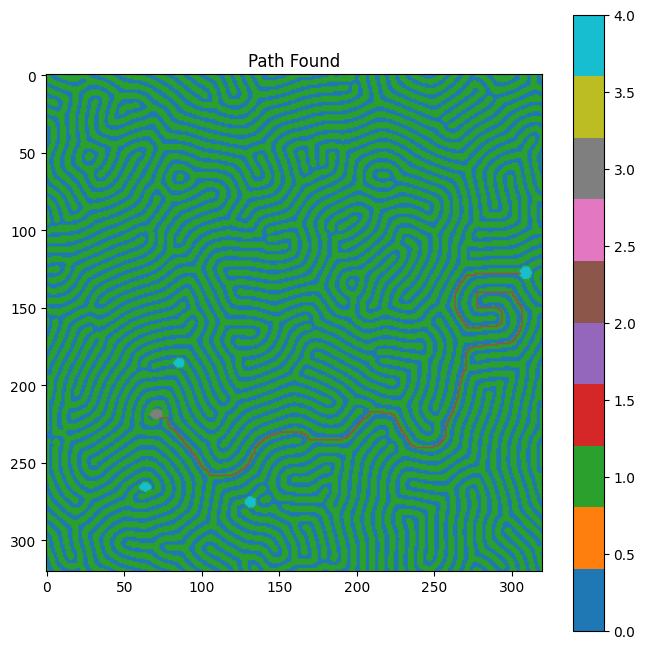

In [41]:
# Visualización del camino con costos dinámicos
visualize_path(grid, path_astar_cost)

······· Experimento Demo ·······


Experimento que demuestra la efectividad de A* con la red neuronal integrada. Se crea un mapa con dos caminos:
- **Camino A (Azul)**: Corto pero caro (Agua - Costo 10)
- **Camino B (Gris)**: Largo pero barato (Pavimento - Costo 1)

El algoritmo debe elegir el camino B para minimizar el costo total.

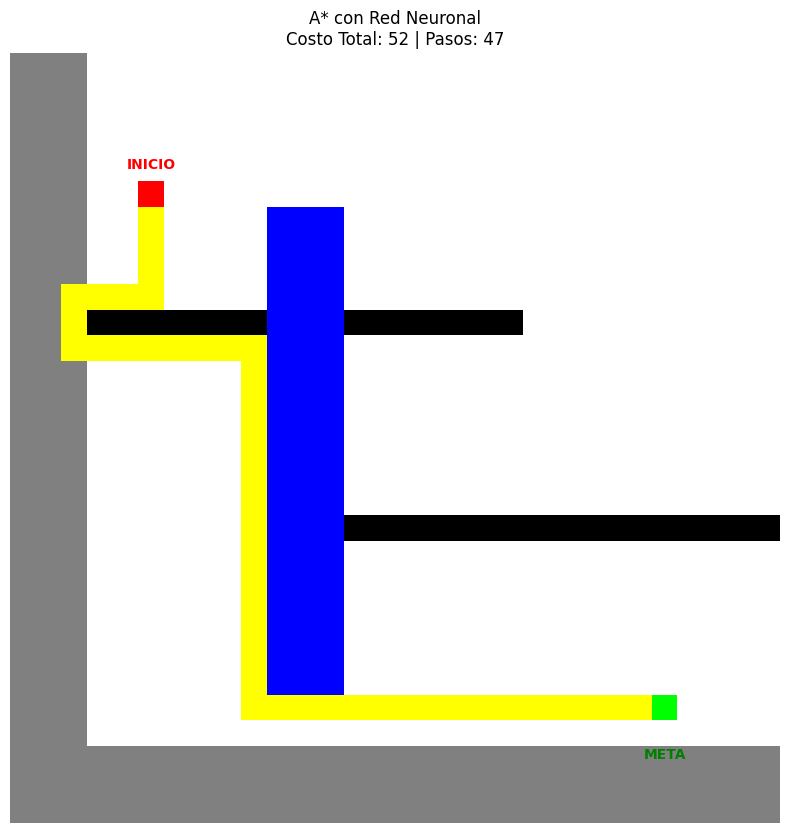

ÉXITO: El robot eligió el camino de pavimento (Camino B).
Costo total calculado: 52


In [42]:
import matplotlib.pyplot as plt
import numpy as np

def run_demo_experiment():
    # 1. Crear el mapa de 30x30
    demo_img = np.ones((30, 30, 3), dtype=np.uint8) * 255 
    
    # Paredes (Negro)
    demo_img[10:11, 0:20] = [0, 0, 0]
    demo_img[18:19, 10:30] = [0, 0, 0]
    
    # Definir posiciones (Fila, Columna)
    start_pos = (5, 5)
    goal_pos = (25, 25)
    
    # CAMINO A: Azul (Agua - Caro)
    demo_img[6:25, 10:13] = [0, 0, 255] 
    
    # CAMINO B: Gris (Pavimento - Barato)
    demo_img[0:30, 0:3] = [128, 128, 128]
    demo_img[27:30, 0:30] = [128, 128, 128]

    # 2. Generar grid lógico
    demo_grid = np.zeros((30, 30), dtype=object)
    for i in range(30):
        for j in range(30):
            r, g, b = demo_img[i, j]
            if r < 50 and g < 50 and b < 50: 
                demo_grid[i, j] = "WALL"
            else: 
                demo_grid[i, j] = "FREE"

    # 3. Configurar Problema
    # tile_size=1 porque cada pixel de demo_img es un nodo
    problem_demo = MazeProblem(demo_grid, start_pos, [goal_pos], demo_img, tile_size=1)
    
    # 4. Ejecutar A*
    path, visited = astar(problem_demo)
    
    if path:
        # 5. Calcular costo real sumando lo que la NN predice
        total_cost = 0
        used_blue = False
        for pos in path[1:]:
            tile_color = demo_img[pos[0], pos[1]]
            pred = predict_color(tile_color)
            cost = color_cost_mapping.get(pred, 5)
            total_cost += cost
            if pred.lower() == "blue": used_blue = True

        # 6. Visualización
        display_img = demo_img.copy()
        for (i, j) in path:
            display_img[i, j] = [255, 255, 0] # Ruta Amarilla
            
        # PUNTOS DE CONTROL: Redibujarlos encima de la ruta
        display_img[start_pos[0], start_pos[1]] = [255, 0, 0] # Rojo
        display_img[goal_pos[0], goal_pos[1]] = [0, 255, 0]   # Verde
            
        plt.figure(figsize=(10, 10))
        plt.imshow(display_img)
        plt.text(start_pos[1], start_pos[0]-1, 'INICIO', color='red', fontweight='bold', ha='center')
        plt.text(goal_pos[1], goal_pos[0]+2, 'META', color='green', fontweight='bold', ha='center')
        
        plt.title(f"A* con Red Neuronal\nCosto Total: {total_cost} | Pasos: {len(path)}")
        plt.axis('off')
        plt.show()
        
        if used_blue:
            print("ALERTA: El robot cruzó por el agua (Camino A).")
        else:
            print("ÉXITO: El robot eligió el camino de pavimento (Camino B).")
            print(f"Costo total calculado: {total_cost}")
    else:
        print("No se encontró ruta.")

run_demo_experiment()

······· Experimento Demo ·······


Experimento que demuestra la efectividad de A* con la red neuronal integrada. Se crea un mapa con dos caminos:
- **Camino A (Azul)**: Corto pero caro (Agua - Costo 10)
- **Camino B (Gris)**: Largo pero barato (Pavimento - Costo 1)

El algoritmo debe elegir el camino B para minimizar el costo total.

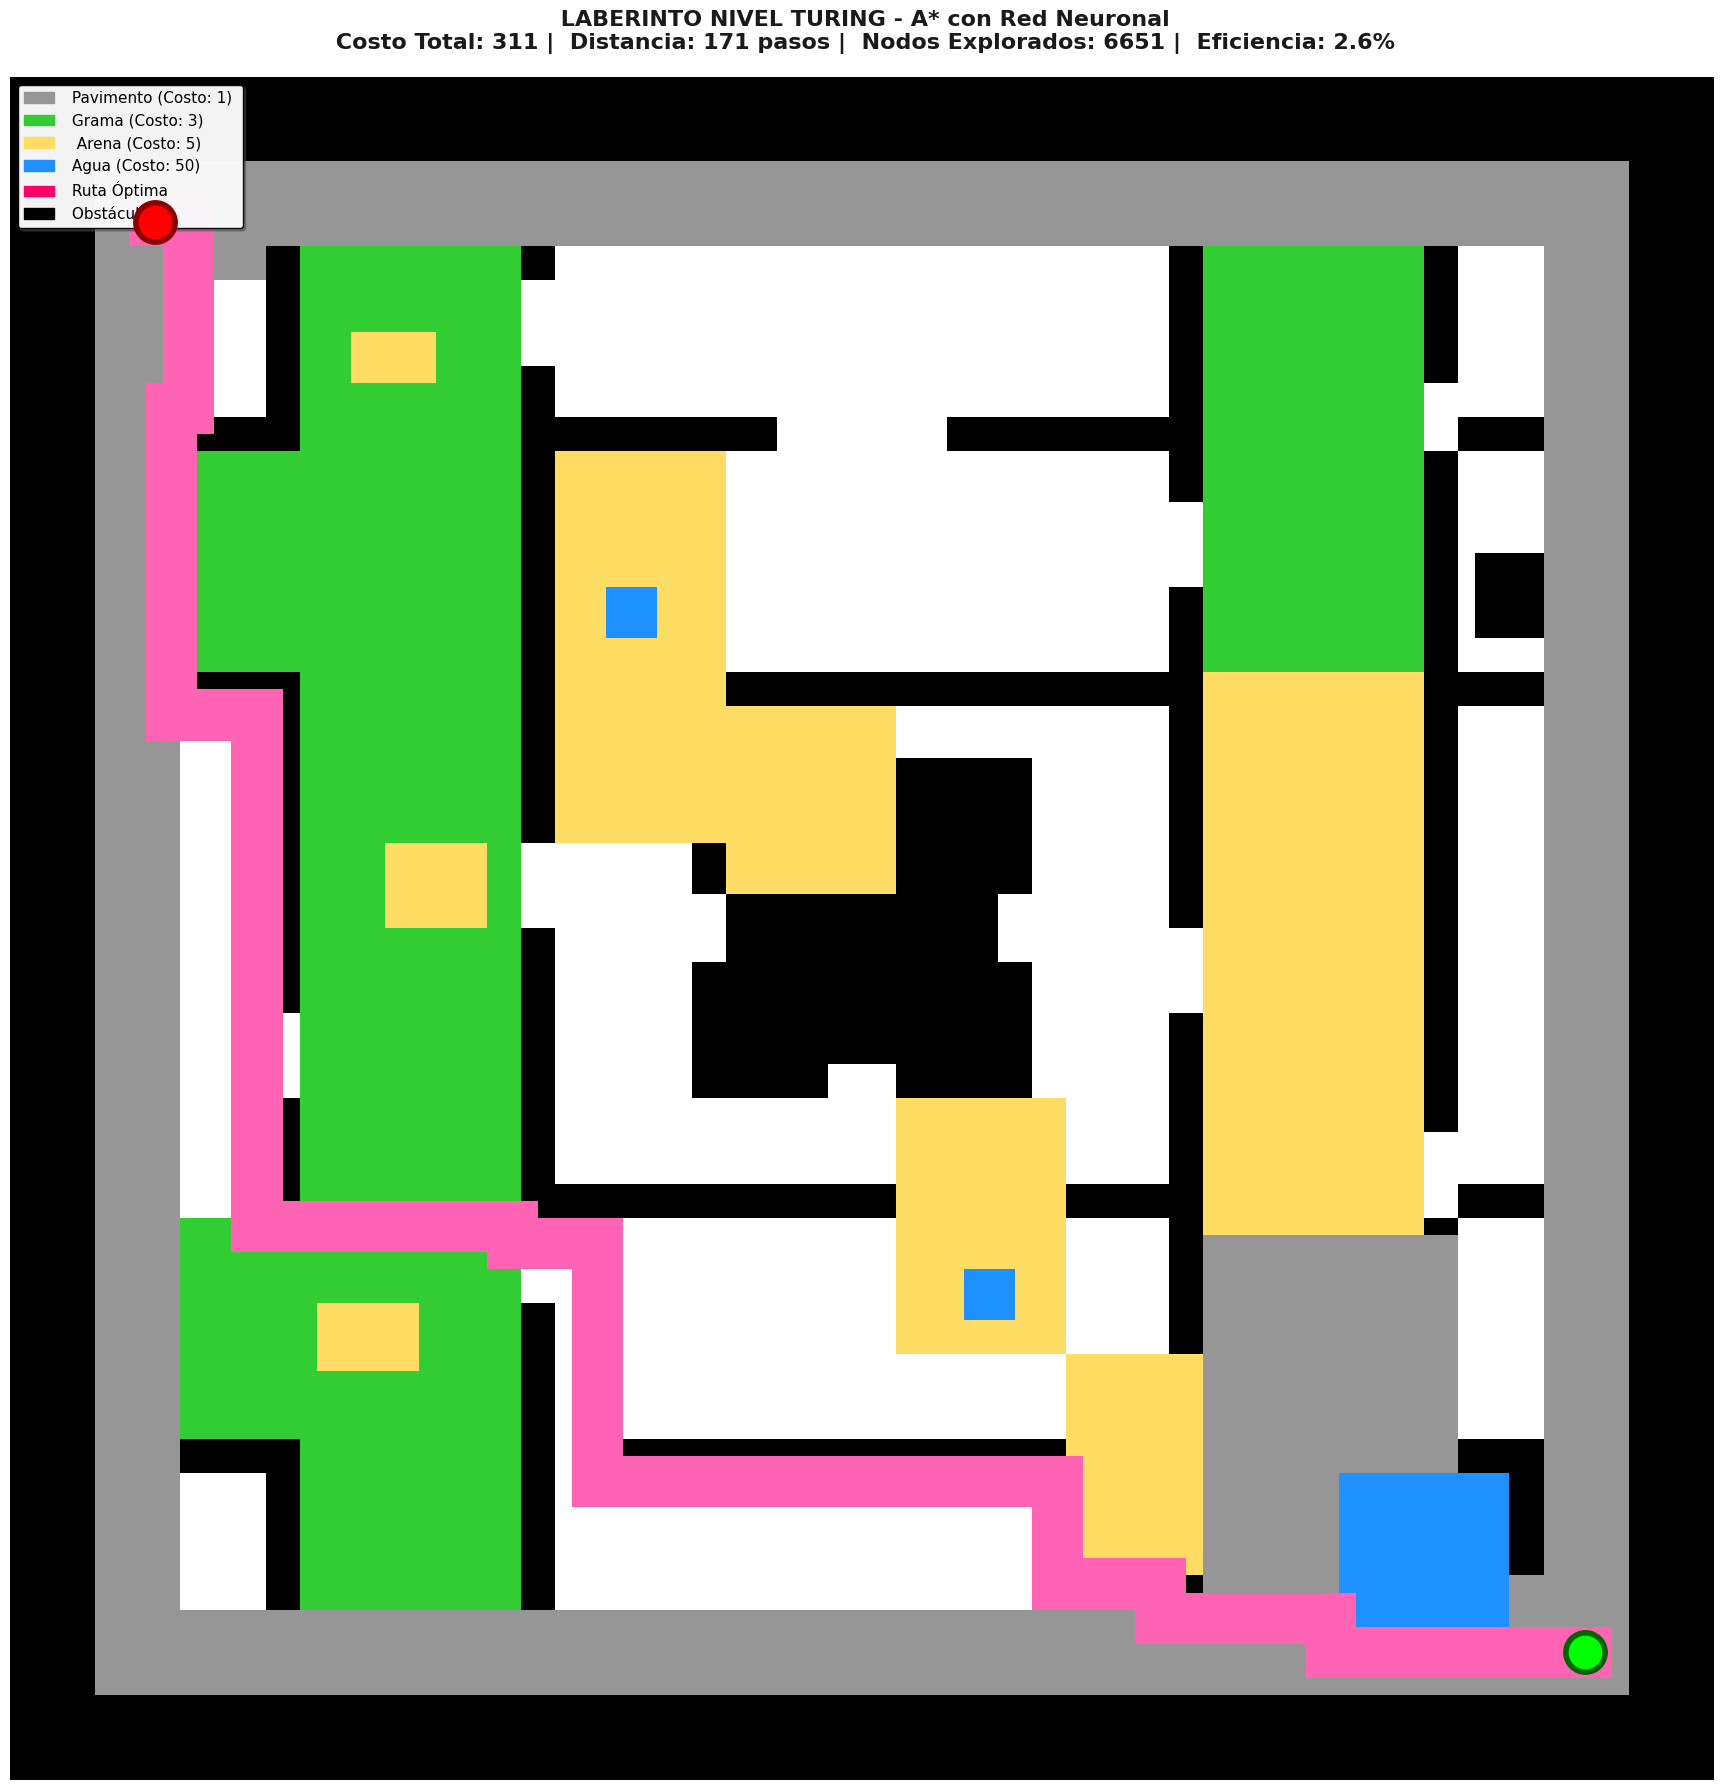


                  ANÁLISIS COMPLETO DE LA RUTA ÓPTIMA                 
 Inicio: (8, 8) ➜ Meta: (92, 92)
 Dimensiones del laberinto: 100×100 (10,000 celdas totales)
 Distancia recorrida: 171 baldosas
----------------------------------------------------------------------
  COMPOSICIÓN DEL TERRENO DE LA RUTA:
   Grey        :  101 baldosas ( 59.1%)
   Green       :   70 baldosas ( 40.9%)
----------------------------------------------------------------------
 COSTO TOTAL: 311
 Nodos Explorados: 6,651
 Eficiencia de Búsqueda: 2.57% (camino/nodos explorados)
 Factor de Ramificación Efectivo: 38.89
----------------------------------------------------------------------
 ÉXITO: El robot evitó completamente el agua
 Decisión Inteligente: A* optimizó costo vs distancia exitosamente



In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def run_hardcore_demo():

    # 1. Configuración del Mapa
    size = 100
    demo_img = np.ones((size, size, 3), dtype=np.uint8) * 255  # Fondo blanco
    
    start_pos = (8, 8)
    goal_pos = (92, 92)
    
    # === 2. CONSTRUCCIÓN DEL LABERINTO COMPLEJO ===
    
    # --- PAREDES EXTERIORES (Marco del laberinto) ---
    demo_img[0:5, :] = [0, 0, 0]  # Tope
    demo_img[95:100, :] = [0, 0, 0]  # Fondo
    demo_img[:, 0:5] = [0, 0, 0]  # Izquierda
    demo_img[:, 95:100] = [0, 0, 0]  # Derecha
    
    # --- SALA CENTRAL (Obstáculo tipo fortaleza) ---
    demo_img[40:60, 40:60] = [0, 0, 0]  # Sala cerrada central
    # Aberturas estratégicas en la sala central
    demo_img[48:52, 40:42] = [255, 255, 255]  # Abertura izquierda
    demo_img[48:52, 58:60] = [255, 255, 255]  # Abertura derecha
    demo_img[40:42, 48:52] = [255, 255, 255]  # Abertura superior
    demo_img[58:60, 48:52] = [255, 255, 255]  # Abertura inferior
    
    # --- CORREDORES HORIZONTALES CON OBSTÁCULOS ---
    # Corredor Superior
    demo_img[20:22, 5:95] = [0, 0, 0]
    demo_img[20:22, 15:20] = [255, 255, 255]  # Gap 1
    demo_img[20:22, 45:55] = [255, 255, 255]  # Gap 2
    demo_img[20:22, 80:85] = [255, 255, 255]  # Gap 3
    
    # Corredor Medio-Superior
    demo_img[35:37, 5:95] = [0, 0, 0]
    demo_img[35:37, 25:30] = [255, 255, 255]  # Gap
    demo_img[35:37, 70:75] = [255, 255, 255]  # Gap
    
    # Corredor Medio-Inferior
    demo_img[65:67, 5:95] = [0, 0, 0]
    demo_img[65:67, 10:15] = [255, 255, 255]  # Gap
    demo_img[65:67, 55:60] = [255, 255, 255]  # Gap
    
    # Corredor Inferior
    demo_img[80:82, 5:95] = [0, 0, 0]
    demo_img[80:82, 30:35] = [255, 255, 255]  # Gap
    demo_img[80:82, 65:70] = [255, 255, 255]  # Gap
    
    # --- CORREDORES VERTICALES (Conectores entre niveles) ---
    # Corredor Izquierdo
    demo_img[5:95, 15:17] = [0, 0, 0]
    demo_img[28:32, 15:17] = [255, 255, 255]  # Gap
    demo_img[55:60, 15:17] = [255, 255, 255]  # Gap
    demo_img[75:78, 15:17] = [255, 255, 255]  # Gap
    
    # Corredor Central-Izquierdo
    demo_img[5:95, 30:32] = [0, 0, 0]
    demo_img[12:17, 30:32] = [255, 255, 255]  # Gap
    demo_img[45:50, 30:32] = [255, 255, 255]  # Gap
    demo_img[68:72, 30:32] = [255, 255, 255]  # Gap
    
    # Corredor Central-Derecho
    demo_img[5:95, 68:70] = [0, 0, 0]
    demo_img[25:30, 68:70] = [255, 255, 255]  # Gap
    demo_img[50:55, 68:70] = [255, 255, 255]  # Gap
    demo_img[85:88, 68:70] = [255, 255, 255]  # Gap
    
    # Corredor Derecho
    demo_img[5:95, 83:85] = [0, 0, 0]
    demo_img[18:22, 83:85] = [255, 255, 255]  # Gap
    demo_img[62:67, 83:85] = [255, 255, 255]  # Gap
    
    # --- OBSTÁCULOS  ---
    # cuadrante superior izquierdo
    demo_img[10:15, 20:28] = [0, 0, 0]
    demo_img[25:30, 6:12] = [0, 0, 0]
    
    # cuadrante superior derecho
    demo_img[12:18, 72:78] = [0, 0, 0]
    demo_img[28:33, 86:92] = [0, 0, 0]
    
    # cuadrante inferior izquierdo
    demo_img[70:76, 8:14] = [0, 0, 0]
    demo_img[85:90, 20:26] = [0, 0, 0]
    
    # cuadrante inferior derecho
    demo_img[68:74, 75:82] = [0, 0, 0]
    demo_img[82:88, 88:94] = [0, 0, 0]
    
    # === 3. DISTRIBUCIÓN DE TERRENOS (4 RUTAS ESTRATÉGICAS) ===
    
    # RUTA 1: PAVIMENTO (Gris - Costo 1)
    demo_img[5:95, 5:10] = [150, 150, 150]  # Borde izquierdo
    demo_img[5:10, 5:95] = [150, 150, 150]  # Borde superior
    demo_img[90:95, 5:95] = [150, 150, 150]  # Borde inferior
    demo_img[5:95, 90:95] = [150, 150, 150]  # Borde derecho
    
    # RUTA 2: GRAMA (Verde - Costo 3) - Camino intermedio por cuadrante izquierdo
    demo_img[10:90, 17:30] = [50, 205, 50]  # Zona verde principal
    demo_img[22:35, 10:17] = [50, 205, 50]  # Conexión
    demo_img[67:80, 10:17] = [50, 205, 50]  # Conexión inferior
    
    # Parches de arena en grama 
    demo_img[15:18, 20:25] = [255, 220, 100]
    demo_img[45:50, 22:28] = [255, 220, 100]
    demo_img[72:76, 18:24] = [255, 220, 100]
    
    # RUTA 3: ARENA (Amarillo - Costo 5) 
    demo_img[22:45, 32:42] = [255, 220, 100]  # Zona superior
    demo_img[37:48, 42:52] = [255, 220, 100]  # Cerca del centro
    demo_img[60:75, 52:62] = [255, 220, 100]  # Zona media
    demo_img[75:88, 62:72] = [255, 220, 100]  # Zona inferior
    
    # TRAMPA: Charcos de agua en arena 
    demo_img[30:33, 35:38] = [30, 144, 255]
    demo_img[70:73, 56:59] = [30, 144, 255]
    
    # RUTA 4: ÁREA DERECHA - Mezcla de terrenos
    demo_img[10:35, 70:83] = [50, 205, 50]  # Grama superior derecha
    demo_img[35:68, 70:83] = [255, 220, 100]  # Arena media derecha
    demo_img[68:90, 70:85] = [150, 150, 150]  # Pavimento inferior derecho
    
    # TRAMPA FINAL: Lago grande cerca de la meta 
    demo_img[82:92, 78:88] = [30, 144, 255]  # Agua bloqueando acceso directo
    
    # === 4. ÁREAS DE CONEXIÓN ===
    # Entrada desde inicio
    demo_img[5:12, 5:15] = [150, 150, 150]
    
    # Salida hacia meta
    demo_img[88:95, 88:95] = [150, 150, 150]
    
    # === 5. GRID LÓGICO ===
    demo_grid = np.zeros((size, size), dtype=object)
    for i in range(size):
        for j in range(size):
            r, g, b = demo_img[i, j]
            if r < 50 and g < 50 and b < 50: 
                demo_grid[i, j] = "WALL"
            else: 
                demo_grid[i, j] = "FREE"

    # === 6. EJECUCIÓN DE A* ===
    problem_demo = MazeProblem(demo_grid, start_pos, [goal_pos], demo_img, tile_size=1)
    path, visited = astar(problem_demo)
    
    if path:
        total_cost = 0
        terrain_counts = {}
        display_img = demo_img.copy()
        
        # Calcular costos y terrenos
        for pos in path:
            tile = demo_img[pos[0], pos[1]]
            pred = predict_color(tile)
            cost = color_cost_mapping.get(pred.lower(), 1)
            total_cost += cost
            terrain_counts[pred] = terrain_counts.get(pred, 0) + 1
        
        # Dibujar ruta 
        for pos in path:
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    ni, nj = pos[0] + di, pos[1] + dj
                    if 0 <= ni < size and 0 <= nj < size:
                        if di == 0 and dj == 0:
                            display_img[ni, nj] = [255, 0, 100]  # Rosa chicle centro
                        else:
                            display_img[ni, nj] = [255, 100, 180]  # Rosa claro bordes

        # === 7. VISUALIZACIÓN  ===
        fig, ax = plt.subplots(figsize=(18, 18))
        ax.imshow(display_img)
        
        # Marcadores s
        ax.scatter(start_pos[1], start_pos[0], c='red', s=800, marker='o', 
                   edgecolors='darkred', linewidths=4, zorder=10, label='INICIO')
        
        ax.scatter(goal_pos[1], goal_pos[0], c='lime', s=800, marker='o', 
                   edgecolors='darkgreen', linewidths=4, zorder=10, label='META')

        # Leyenda mejorada
        legend_elements = [
            mpatches.Patch(color=[150/255, 150/255, 150/255], label=' Pavimento (Costo: 1) '),
            mpatches.Patch(color=[50/255, 205/255, 50/255], label=' Grama (Costo: 3)'),
            mpatches.Patch(color=[1, 220/255, 100/255], label='  Arena (Costo: 5)'),
            mpatches.Patch(color=[30/255, 144/255, 1], label=' Agua (Costo: 50) '),
            mpatches.Patch(color=[1, 0, 100/255], label=' Ruta Óptima'),
            mpatches.Patch(color=[0, 0, 0], label=' Obstáculos'),
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=11, 
                  framealpha=0.95, edgecolor='black', fancybox=True, shadow=True)

        # Título épico
        efficiency = (len(path) / visited) * 100
        ax.set_title(
            f" LABERINTO NIVEL TURING - A* con Red Neuronal\n" +
            f" Costo Total: {total_cost} |  Distancia: {len(path)} pasos | " +
            f" Nodos Explorados: {visited} |  Eficiencia: {efficiency:.1f}%", 
            fontsize=16, fontweight='bold', pad=20, color='#1A1A1A'
        )
        ax.axis('off')
        plt.tight_layout()
        plt.show()

        # === 8. REPORTE DETALLADO ===
        print("\n" + "="*70)
        print("   ANÁLISIS COMPLETO DE LA RUTA ÓPTIMA  ".center(70))
        print("="*70)
        print(f" Inicio: {start_pos} ➜ Meta: {goal_pos}")
        print(f" Dimensiones del laberinto: {size}×{size} ({size*size:,} celdas totales)")
        print(f" Distancia recorrida: {len(path)} baldosas")
        print("-" * 70)
        print("  COMPOSICIÓN DEL TERRENO DE LA RUTA:")
        for terrain, count in sorted(terrain_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / len(path)) * 100
            print(f"   {terrain:12}: {count:4} baldosas ({percentage:5.1f}%)")
        print("-" * 70)
        print(f" COSTO TOTAL: {total_cost}")
        print(f" Nodos Explorados: {visited:,}")
        print(f" Eficiencia de Búsqueda: {efficiency:.2f}% (camino/nodos explorados)")
        print(f" Factor de Ramificación Efectivo: {visited/len(path):.2f}")
        print("-" * 70)
        
        # Análisis estratégico
        water_tiles = terrain_counts.get('Blue', 0) + terrain_counts.get('blue', 0)
        if water_tiles > 0:
            print("  ALERTA: El robot tuvo que cruzar AGUA (puede ser inevitable)")
        else:
            print(" ÉXITO: El robot evitó completamente el agua")
        
        print(f" Decisión Inteligente: A* optimizó costo vs distancia exitosamente")
        print("="*70 + "\n")
    else:
        print(" ERROR: No se encontró una ruta válida en el laberinto.")

run_hardcore_demo()